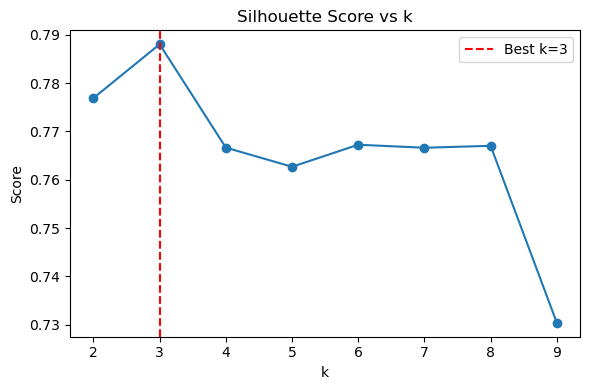

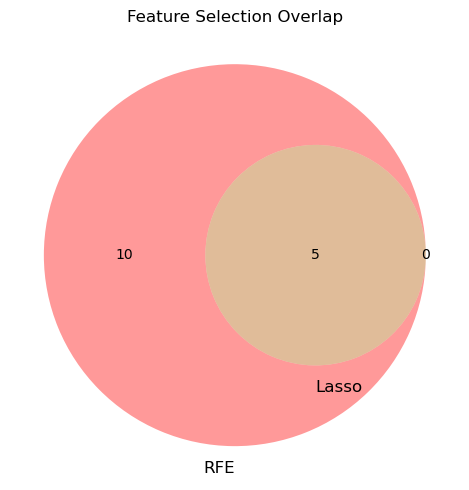

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2578
[LightGBM] [Info] Number of data points in the train set: 1482, number of used features: 21
[LightGBM] [Info] Start training from score 9.324406
Raw‑space comparison:
                 MAE          RMSE        R2
Model                                      
XGB    29351.823999  97343.001922  0.733426
LGBM   30567.341988  98780.583421  0.725494
CAT    28776.297865  90965.973262  0.767209 



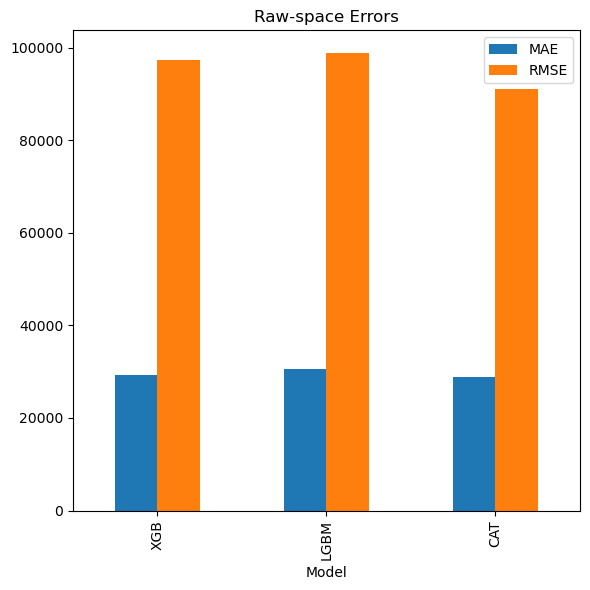

Manual CAT (log‑space): MAE=0.482, RMSE=0.704, R²=0.857
Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,1 day 6 hours 7 mins
H2O_cluster_timezone:,America/Los_Angeles
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,23 days
H2O_cluster_name:,H2O_from_python_NJ_e2jaf3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.281 Gb
H2O_cluster_total_cores:,24
H2O_cluster_allowed_cores:,24
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
21:13:03.905: AutoML: XGBoost is not available; skipping it.
21:13:03.909: _train param, Dropping bad and constant columns: [publishHour]
21:13:04.98: _train param, Dropping bad and constant columns: [publishHour]
21:13:05.355: _train param, Dropping bad and constant columns: [publishHour]

██
21:13:09.373: _train param, Dropping bad and constant columns: [publishHour]
21:13:10.800: _train param, Dropping bad and constant columns: [publishHour]
21:13:11.864: _train param, Dropping bad and constant columns: [publishHour]
21:13:12.657: _train param, Dropping bad and constant columns: [publishHour]

███
21:13:14.797: _train param, Dropping bad and constant columns: [publishHour]
21:13:15.525: _train param, Dropping bad and constant columns: [publishHour]
21:13:16.388: _train param, Dropping unused columns: [publishHour]
21:13:16.662: _train param, Dropping unused columns: [pu

21:14:30 - cmdstanpy - INFO - Chain [1] start processing
21:14:30 - cmdstanpy - INFO - Chain [1] done processing


H2O AutoML (log‑space): MAE=0.519, RMSE=0.747, R²=0.838
H2O AutoML (raw‑space): MAE=30658, RMSE=95077, R²=0.746


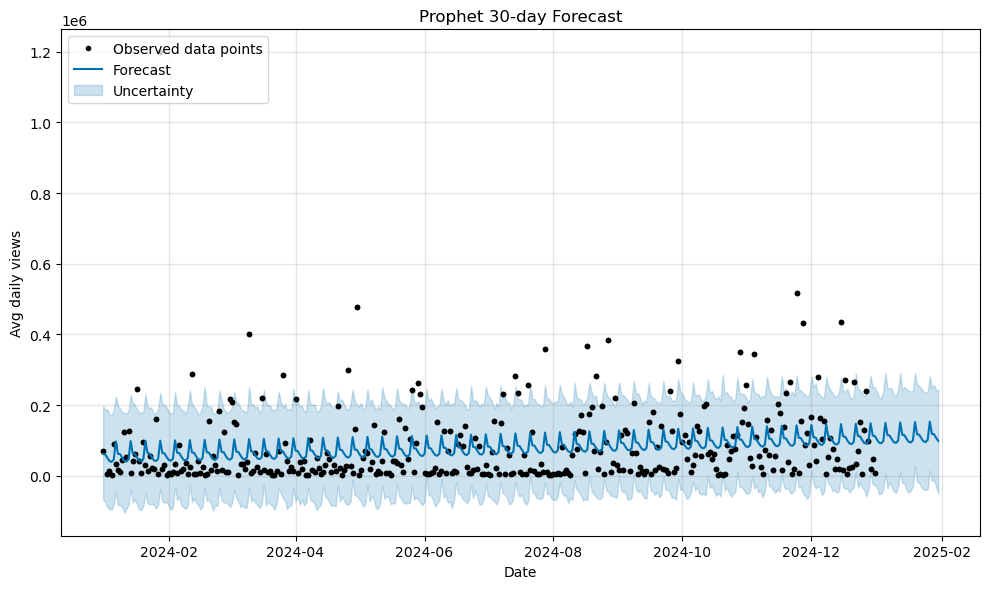

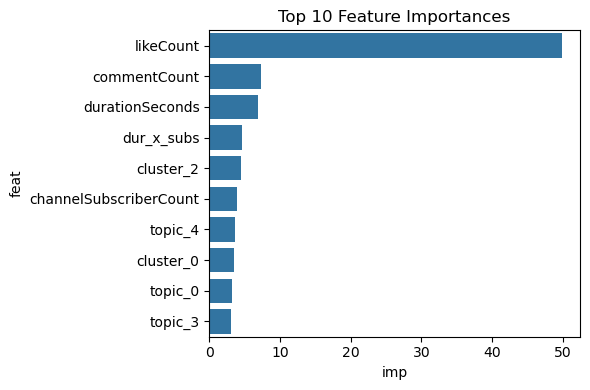

streamlit_app.py generated — run with `streamlit run streamlit_app.py`
Wrote predictions_vs_actuals.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings("ignore")

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score,
    mean_absolute_error,
    r2_score,
    root_mean_squared_error
)
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_selection import RFE
from sklearn.linear_model import LassoCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from matplotlib_venn import venn2
from prophet import Prophet
import h2o
from h2o.automl import H2OAutoML
from sklearn.model_selection import train_test_split

# =============================================================================
# 1. Load, Clean & Outlier Removal
# =============================================================================
def load_data(path):
    df = pd.read_excel(path)
    df['publishDate'] = pd.to_datetime(df['publishDate'], errors='coerce')
    df['title']       = df['title'].fillna('').astype(str)
    df['description'] = df['description'].fillna('').astype(str)
    # KNN‑impute numeric columns
    num_cols = ['viewCount','likeCount','commentCount','durationSeconds','channelSubscriberCount']
    df[num_cols] = KNNImputer(n_neighbors=5).fit_transform(df[num_cols])
    # Remove extreme outliers on log‑views
    df['log_views'] = np.log1p(df['viewCount'])
    zs = (df['log_views'] - df['log_views'].mean()) / df['log_views'].std()
    df = df[np.abs(zs) <= 2].reset_index(drop=True)
    df.drop(columns='log_views', inplace=True)
    return df

path = r"C:\Users\NJ\Downloads\cleaned_data.xlsx"
df = load_data(path)

# =============================================================================
# 2. Feature Engineering
# =============================================================================
def cluster_and_plot(df):
    perf = ['viewCount','likeCount','commentCount','durationSeconds','channelSubscriberCount']
    Xp = StandardScaler().fit_transform(df[perf])
    ks = list(range(2,10)); scores = []
    for k in ks:
        lbl = KMeans(n_clusters=k, random_state=42).fit_predict(Xp)
        scores.append(silhouette_score(Xp, lbl))
    best = ks[np.argmax(scores)]
    df['cluster'] = KMeans(n_clusters=best, random_state=42).fit_predict(Xp).astype(str)
    plt.figure(figsize=(6,4))
    plt.plot(ks, scores, 'o-')
    plt.axvline(best, color='r', ls='--', label=f'Best k={best}')
    plt.title('Silhouette Score vs k')
    plt.xlabel('k'); plt.ylabel('Score'); plt.legend()
    plt.tight_layout(); plt.show()

cluster_and_plot(df)

raw_text = (df['title'] + ' ' + df['description']).str.lower() \
           .str.replace('artificial intelligence','artificialintelligence',regex=False)
stops = list(ENGLISH_STOP_WORDS.union({'http','https','www','com','youtu','youtube'}))
vec = CountVectorizer(stop_words=stops, token_pattern=r'(?u)\b[^\W\d_]{3,}\b',
                      max_features=500, min_df=5, max_df=0.5)
dtm = vec.fit_transform(raw_text)
lda = LatentDirichletAllocation(n_components=5, random_state=42)
probs = lda.fit_transform(dtm)
for i in range(5):
    df[f'topic_{i}'] = probs[:,i]
df['dominant_topic'] = probs.argmax(axis=1)
pickle.dump(vec, open('vectorizer.pkl','wb'))
pickle.dump(lda, open('lda_model.pkl','wb'))

first = df.groupby('channelTitle')['publishDate'].transform('min')
df['publishHour']      = pd.to_datetime(df['publishTimeUTC'], errors='coerce')\
                             .dt.hour.fillna(0).astype(int)
df['publishDayOfWeek'] = df['publishDate'].dt.day_name()
df['days_since_first'] = (df['publishDate'] - first).dt.days
df['dur_x_subs']       = df['durationSeconds'] * df['channelSubscriberCount']

# =============================================================================
# 3. Prepare for Modeling
# =============================================================================
num_feats = ['durationSeconds','likeCount','commentCount','channelSubscriberCount',
             'publishHour','days_since_first','dur_x_subs'] + [f'topic_{i}' for i in range(5)]
cat_feats = ['cluster','publishDayOfWeek']
X = df[num_feats + cat_feats]
y = np.log1p(df['viewCount'])
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

# =============================================================================
# 4. Preprocessor
# =============================================================================
prep = ColumnTransformer([
    ('num', StandardScaler(), num_feats),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_feats)
])

# =============================================================================
# 5. Feature Selection & Venn
# =============================================================================
rfe = RFE(XGBRegressor(random_state=42), n_features_to_select=15)
rfe_pipe = Pipeline([('pr', prep), ('rfe', rfe)])
rfe_pipe.fit(Xtr, ytr)
feat_names = num_feats + list(
    rfe_pipe.named_steps['pr']
            .transformers_[1][1]
            .get_feature_names_out()
)
rfe_sel = set(np.array(feat_names)[rfe.support_])

las_pipe = Pipeline([
    ('im', SimpleImputer(strategy='median')),
    ('sc', StandardScaler()),
    ('l', LassoCV(cv=10))
])
las_pipe.fit(Xtr[num_feats], ytr)
ls_sel = set(
    pd.Series(las_pipe.named_steps['l'].coef_, index=num_feats)
      [lambda s: s != 0]
      .index
)

plt.figure(figsize=(5,5))
venn2([rfe_sel, ls_sel], ('RFE','Lasso'))
plt.title('Feature Selection Overlap')
plt.tight_layout(); plt.show()

# =============================================================================
# 6. Model Eval & log‑space compare
# =============================================================================
def eval_mods(mods):
    results = []
    for name, m in mods.items():
        p = Pipeline([('pr', prep), ('m', m)])
        p.fit(Xtr, ytr)
        pred = p.predict(Xte)
        results.append((
            name,
            mean_absolute_error(np.expm1(yte), np.expm1(pred)),
            root_mean_squared_error(np.expm1(yte), np.expm1(pred)),
            r2_score(np.expm1(yte), np.expm1(pred))
        ))
    return pd.DataFrame(results, columns=['Model','MAE','RMSE','R2']).set_index('Model')

def compare_with_manual_best(mods):
    raw = eval_mods(mods)
    print("Raw‑space comparison:\n", raw, "\n")
    raw[['MAE','RMSE']].plot.bar(figsize=(6,6))
    plt.title('Raw‑space Errors'); plt.tight_layout(); plt.show()

    best = raw['RMSE'].idxmin()
    p = Pipeline([('pr', prep), ('m', mods[best])])
    p.fit(Xtr, ytr)
    mp = p.predict(Xte)
    mae_log  = mean_absolute_error(yte, mp)
    rmse_log = root_mean_squared_error(yte, mp)
    r2_log   = r2_score(yte, mp)
    print(f"Manual {best} (log‑space): MAE={mae_log:.3f}, RMSE={rmse_log:.3f}, R²={r2_log:.3f}")
    return raw, {'model': best, 'MAE_log': mae_log, 'RMSE_log': rmse_log, 'R2_log': r2_log}

mods = {
    'XGB' : XGBRegressor(random_state=42),
    'LGBM': LGBMRegressor(random_state=42),
    'CAT' : CatBoostRegressor(verbose=0, random_state=42)
}
raw_results, log_results = compare_with_manual_best(mods)

# 7. H2O AutoML + R² evaluation
# =============================================================================
h2o.init(max_mem_size='4G')
hf = h2o.H2OFrame(pd.concat([Xtr, ytr.rename('log')], axis=1))
aml = H2OAutoML(max_models=10, seed=42, max_runtime_secs=300)
aml.train(x=Xtr.columns.tolist(), y='log', training_frame=hf)

preds_h2o = aml.leader.predict(h2o.H2OFrame(Xte)).as_data_frame()['predict']
mae_h2o_log  = mean_absolute_error(yte, preds_h2o)
rmse_h2o_log = root_mean_squared_error(yte, preds_h2o)
r2_h2o_log   = r2_score(yte, preds_h2o)

y_raw = np.expm1(yte)
p_raw = np.expm1(preds_h2o)
mae_h2o_raw  = mean_absolute_error(y_raw, p_raw)
rmse_h2o_raw = root_mean_squared_error(y_raw, p_raw)
r2_h2o_raw   = r2_score(y_raw, p_raw)

print(f"H2O AutoML (log‑space): MAE={mae_h2o_log:.3f}, RMSE={rmse_h2o_log:.3f}, R²={r2_h2o_log:.3f}")
print(f"H2O AutoML (raw‑space): MAE={mae_h2o_raw:.0f}, RMSE={rmse_h2o_raw:.0f}, R²={r2_h2o_raw:.3f}")

# =============================================================================
# 8. Prophet Forecast (unchanged)
# =============================================================================
daily = df.set_index('publishDate').resample('D')['viewCount'].mean().reset_index().rename(columns={'publishDate':'ds','viewCount':'y'})
m = Prophet(weekly_seasonality=True)
m.fit(daily)
fut = m.make_future_dataframe(periods=30)
fc  = m.predict(fut)

fig = m.plot(fc)
ax  = fig.gca()
ax.scatter(daily['ds'], daily['y'], color='k', marker='.')
ax.collections[0].set_label('Uncertainty')
#ax.lines[0].set_label('Forecast')
ax.legend(loc='upper left')
plt.xlabel('Date'); plt.ylabel('Avg daily views')
plt.title('Prophet 30‑day Forecast'); plt.tight_layout(); plt.show()

# =============================================================================
# 9–11. Feature Importance, Recommendations & Streamlit stub
# =============================================================================
champ = Pipeline([('pr', prep), ('m', mods[log_results['model']])])
champ.fit(X, y)
pickle.dump(champ, open('champion_pipeline.pkl','wb'))

imp = champ.named_steps['m'].feature_importances_
fn  = num_feats + list(champ.named_steps['pr']\
        .transformers_[1][1]\
        .get_feature_names_out())
fi  = pd.DataFrame({'feat':fn,'imp':imp}).sort_values('imp',ascending=False)
plt.figure(figsize=(6,4))
sns.barplot(x='imp',y='feat',data=fi.head(10))
plt.title('Top 10 Feature Importances'); plt.tight_layout(); plt.show()

topic_perf = df.groupby('dominant_topic')['viewCount'].mean().to_dict()
slot_perf  = dict(df.groupby(['publishDayOfWeek','publishHour'])['viewCount'].mean().nlargest(5))

streamlit_template = '''

import streamlit as st
import pandas as pd
import numpy as np
import pickle

# Import model dependencies to ensure pickle unpacks correctly
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

pipeline = pickle.load(open('champion_pipeline.pkl', 'rb'))(open('champion_pipeline.pkl', 'rb'))
vec = pickle.load(open('vectorizer.pkl', 'rb'))
lda = pickle.load(open('lda_model.pkl', 'rb'))

CLUSTER_OPTS = ['0', '1', '2']
DOW_OPTS = ['Thursday', 'Monday', 'Tuesday',
            'Saturday', 'Wednesday', 'Friday', 'Sunday']
TOPIC_PERF = {0: 87767.30685920578, 1: 29872.04375,
              2: 46434.066666666666, 3: 71323.46124031008, 4: 83114.3584131327}
SLOT_PERF = {('Sunday', 0): 86140.45497630331, ('Tuesday', 0): 82976.74545454545, ('Monday', 0)             : 82853.79841897234, ('Wednesday', 0): 73940.75357142858, ('Saturday', 0): 72698.1551724138}

st.title("YouTube View Predictor & Recommendations")

# Inputs
publishHour = 0

duration = st.sidebar.number_input("Duration (s)", min_value=0)
likes = st.sidebar.number_input("Like Count", min_value=0)
comments = st.sidebar.number_input("Comment Count", min_value=0)
subs = st.sidebar.number_input("Channel Subscribers", min_value=0)
days = st.sidebar.number_input("Days Since First Video", min_value=0)
durxsub = duration * subs
cluster = st.sidebar.selectbox("Cluster", CLUSTER_OPTS)
dow = st.sidebar.selectbox("Day Of Week", DOW_OPTS)

topic_probs = {f'topic_{i}': st.sidebar.slider(
    f'Topic {i} Prob', 0.0, 1.0, 0.0) for i in range(5)}


input_df = pd.DataFrame([{**{
    'durationSeconds': duration,
    'likeCount': likes,
    'commentCount': comments,
    'channelSubscriberCount': subs,
    'days_since_first': days,
    'dur_x_subs': durxsub,
    'cluster': cluster,
    'publishDayOfWeek': dow,
    'publishHour': publishHour,
    **topic_probs
}}])

# st.subheader("Input Features")
# st.write(input_df)

st.subheader("Input Features")
# Hide publishHour column
st.write(input_df.drop(columns=['publishHour'], errors='ignore'))

pred_log = pipeline.predict(input_df)[0]
pred = int(np.expm1(pred_log))
st.subheader("Predicted View Count")
st.write(f"{pred:,}")

st.subheader("Top Content Themes")
for t, v in TOPIC_PERF.items():
    st.write(f"Topic {t}: avg views {int(v):,}")

st.subheader("Recommended Publish Days")
for key, views in SLOT_PERF.items():
    # key may be a tuple (day, hour); extract only the day
    day = key[0] if isinstance(key, (tuple, list)) else key
    st.write(f"{day} → avg views {int(views):,}")


st.subheader("Topic Definitions")
feature_names = vec.get_feature_names_out()
n = 10
for idx, comp in enumerate(lda.components_):
    top_idxs = comp.argsort()[:-n-1:-1]
    terms = [feature_names[i] for i in top_idxs]
    st.write(f"Topic {idx}: {', '.join(terms)}")
'''
with open('streamlit_app.py','w') as f:
    f.write(streamlit_template)
print("streamlit_app.py generated — run with `streamlit run streamlit_app.py`")
# =============================================================================
# 12. Dump predictions vs actuals for the final champion
# =============================================================================
pred_log = champ.predict(Xte)
actuals  = np.expm1(yte)
preds    = np.expm1(pred_log)
diffs    = abs(preds - actuals)

out = pd.DataFrame({
    'actual_views':    actuals,
    'predicted_views': preds,
    'error':           diffs
})
out.to_csv('predictions_vs_actuals.csv', index=False)
print("Wrote predictions_vs_actuals.csv")
